In [11]:
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import cdd
from modulus_tools import demo_graphs
from modulus_tools import algorithms as alg
from itertools import product

In [12]:
'slit trees with weights in edges'
def split_ew(G,w,ep):
    for i, (u,v) in enumerate(G.edges()):
        G[u][v]['enum'] = i
    for (a,b) in G.edges():
        H = G.copy()
        H.remove_edge(a,b)
        C =nx.connected_components(H)
        c= list(C)
        K = nx.Graph()
        c0= 0
        c1=0
        for u,v,d in H.edges(data=True):
            if u in c[0]:
                if v in c[0]:
                    c0= c0 + w[G[u][v]['enum']]
        for u,v,d in H.edges(data=True):
            if u in c[1]:
                if v in c[1]:
                    c1= c1 + w[G[u][v]['enum']]
        if abs(c0-c1)< ep :
            print('Splittable')
            print((a,b))
'split trees with weights in nodes'
def split_dw(G,w,ep):
    unsplittable = True
    for (a,b) in G.edges():
        H = G.copy()
        H.remove_edge(a,b)
        C =nx.connected_components(H)
        c= list(C)
        c0= sum(w[u] for u in c[0])
        c1=sum(w[u] for u in c[1])
        if abs(c0-c1)< ep+1 :
            unsplittable = False
            #print('Splittable')
            #print((a,b))
    if unsplittable is True:
        print('not - splittable')
    else:
        print('splittable')
'Minimum value of the optimal tree splitting'
def svalue(G,w):
    value = sum(w)
    cut = 0
    for (a,b) in G.edges():
        H = G.copy()
        H.remove_edge(a,b)
        C =nx.connected_components(H)
        c= list(C)
        c0= sum(w[u] for u in c[0])
        c1=sum(w[u] for u in c[1])
        if abs(c0-c1) < value :
            cut = (a,b)
            value = abs(c0-c1)
    return value, cut

In [13]:
'Computing modulus using fast algorithms'
def MOD(G):
    from modulus_tools.basic_algorithm import matrix_modulus, modulus
    from modulus_tools.families.networkx_families import MinimumSpanningTree
    from minimum_degree import VertexbasedMinimumSpanningTree
    m = len(G.nodes())
    pos = nx.spring_layout(G)
    mst = VertexbasedMinimumSpanningTree(G)
    mod, cons, rho, lam = modulus(m, matrix_modulus, mst, max_iter=400)
    print('modulus =', mod)
    print('rho =',rho)
    plt.figure(figsize=(6,6))
    nx.draw(G, pos, node_size=300, edge_color='black', width=2, node_color = np.around(rho,10), cmap=plt.cm.Set2)
    labels = {u:u for u in G.nodes}
    nx.draw_networkx_labels(G, pos,labels=labels, font_size=12)
    return mod, cons, rho, lam

In [14]:
def matrix_modulus(N, p=2, sigma=None):
    import cvxpy as cvx
    import numpy as np

    from warnings import warn
    
    # problem dimension
    m = N.shape[1]
    
    # set sigma to default if necessary
    if sigma is None:
        sigma = np.ones(m)
    
    # convert inputs to cvxpy constants
    N = cvx.Constant(N)
    sigma = cvx.Constant(sigma)
    
    # primal variables
    rho = cvx.Variable(m)
    
    # objective
    if p is not np.inf:
        obj = cvx.Minimize(sigma.T@rho**p)
    else:
        obj = cvx.Minimize(cvx.max(cvx.multiply(sigma, rho)))
        
    # constraints
    cons = [rho >= 0, N@rho >= 1]
    
    # set up the problem
    prob = cvx.Problem(obj, cons)
    
    # attempt to solve
    prob.solve()
    if prob.status != 'optimal':
        warn('cvxpy solve returned status {}'.format(prob.status))
        
    return prob.value, np.array(rho.value).flatten(), np.array(cons[1].dual_value).flatten()

In [15]:
def matrixtree(G):
    for i, (u,v) in enumerate(G.edges()):
        G[u][v]['enum'] = i
    # get a list of spanning trees
    trees = list(alg.spanning_trees(G))
    # count the number of edges
    m = len(G.nodes)
    # initialize an empty list of rows for the augmented matrix
    rows = []
    for tree in trees:
        H = nx.Graph(tree)
        row = m*[0]
        for u in H.nodes:
            row[u] = H.degree[u]
        rows.append(row) 
    return np.array(rows)



In [16]:
def drawfair(G,ep):
    trees = list(alg.spanning_trees(G))
    N = matrixtree(G)
    mod,rho,lamb = matrix_modulus(N,p=2, sigma=None)
    la = np.round(lamb/sum(lamb),8)
    n= len(G.nodes())
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_size=20, node_color =np.round(rho,5), edge_color='tab:blue', width=2)
    #G = nx.random_geometric_graph(n, 0.3, seed=seed)
    w = np.ones(n)
    ncol = 4
    nrow = int(np.ceil(400/ncol))
    plt.figure(figsize=(3*ncol,3*nrow))
    a=0
    b=0
    for i,tree in enumerate(trees):
        if la[i]>0:
            a=a+1
            H= nx.Graph(tree)
            plt.subplot(nrow,ncol,a)
            value,cut = svalue(H,w)
            if value < ep+1:
                pos = nx.spring_layout(H)
                nx.draw(H, pos, node_size=20, edge_color='tab:blue', width=2, node_color = 'black')
                labels = {cut:value}
                nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=12)
            else:
                b=b+1
                pos = nx.spring_layout(H)
                ax = plt.gca()
                ax.set_title(la[i])
                nx.draw(H, pos, node_size=20, edge_color='yellow', width=2, node_color = 'black',ax=ax)
                labels = {cut:value}
                nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=12)
    print('number of fair trees =',a)
    print('number of unsplittable fair trees =',b)
    print('number of trees =',len(trees))
    expected = 0
    for i,tree in enumerate(trees):
        H= nx.Graph(tree)
        value,cut = svalue(H,w)
        expected = expected + la[i]*value
    print('expected value of cut = ',expected)
        

In [17]:
def drawbadfair(G,ep):
    trees = list(alg.spanning_trees(G))
    N = matrixtree(G)
    mod,rho,lamb = matrix_modulus(N,p=2, sigma=None)
    la = np.round(lamb/sum(lamb),8)
    n= len(G.nodes())
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_size=20, node_color =np.round(rho,5), edge_color='tab:blue', width=2)
    #G = nx.random_geometric_graph(n, 0.3, seed=seed)
    w = np.ones(n)
    ncol = 4
    nrow = int(np.ceil(400/ncol))
    plt.figure(figsize=(3*ncol,3*nrow))
    a=0
    b=0
    for i,tree in enumerate(trees):
        if la[i]>0:
            a=a+1
            H= nx.Graph(tree)
            value,cut = svalue(H,w)
            if value > ep:
                b=b+1
                plt.subplot(nrow,ncol,b)    
                pos = nx.spring_layout(H)
                ax = plt.gca()
                ax.set_title(la[i])
                nx.draw(H, pos, node_size=20, edge_color='yellow', width=2, node_color = 'black', ax =ax)    
                labels = {cut:value}
                nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=12)
    print('number of fair trees =',a)
    print('number of unsplittable fair trees =',b)
    print('number of trees =',len(trees))
    expected =0
    for i,tree in enumerate(trees):
        H= nx.Graph(tree)
        value,cut = svalue(H,w)
        expected = expected + la[i]*value
    print('expected value of cut = ',expected)

number of fair trees = 287
number of unsplittable fair trees = 64
number of trees = 2415
expected value of cut =  0.4504861999999998
[0.04545455 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455
 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455]
var= 0.0
maxla= 0.01846307


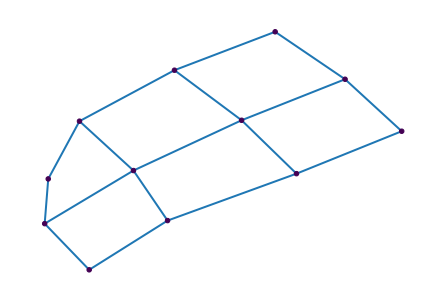

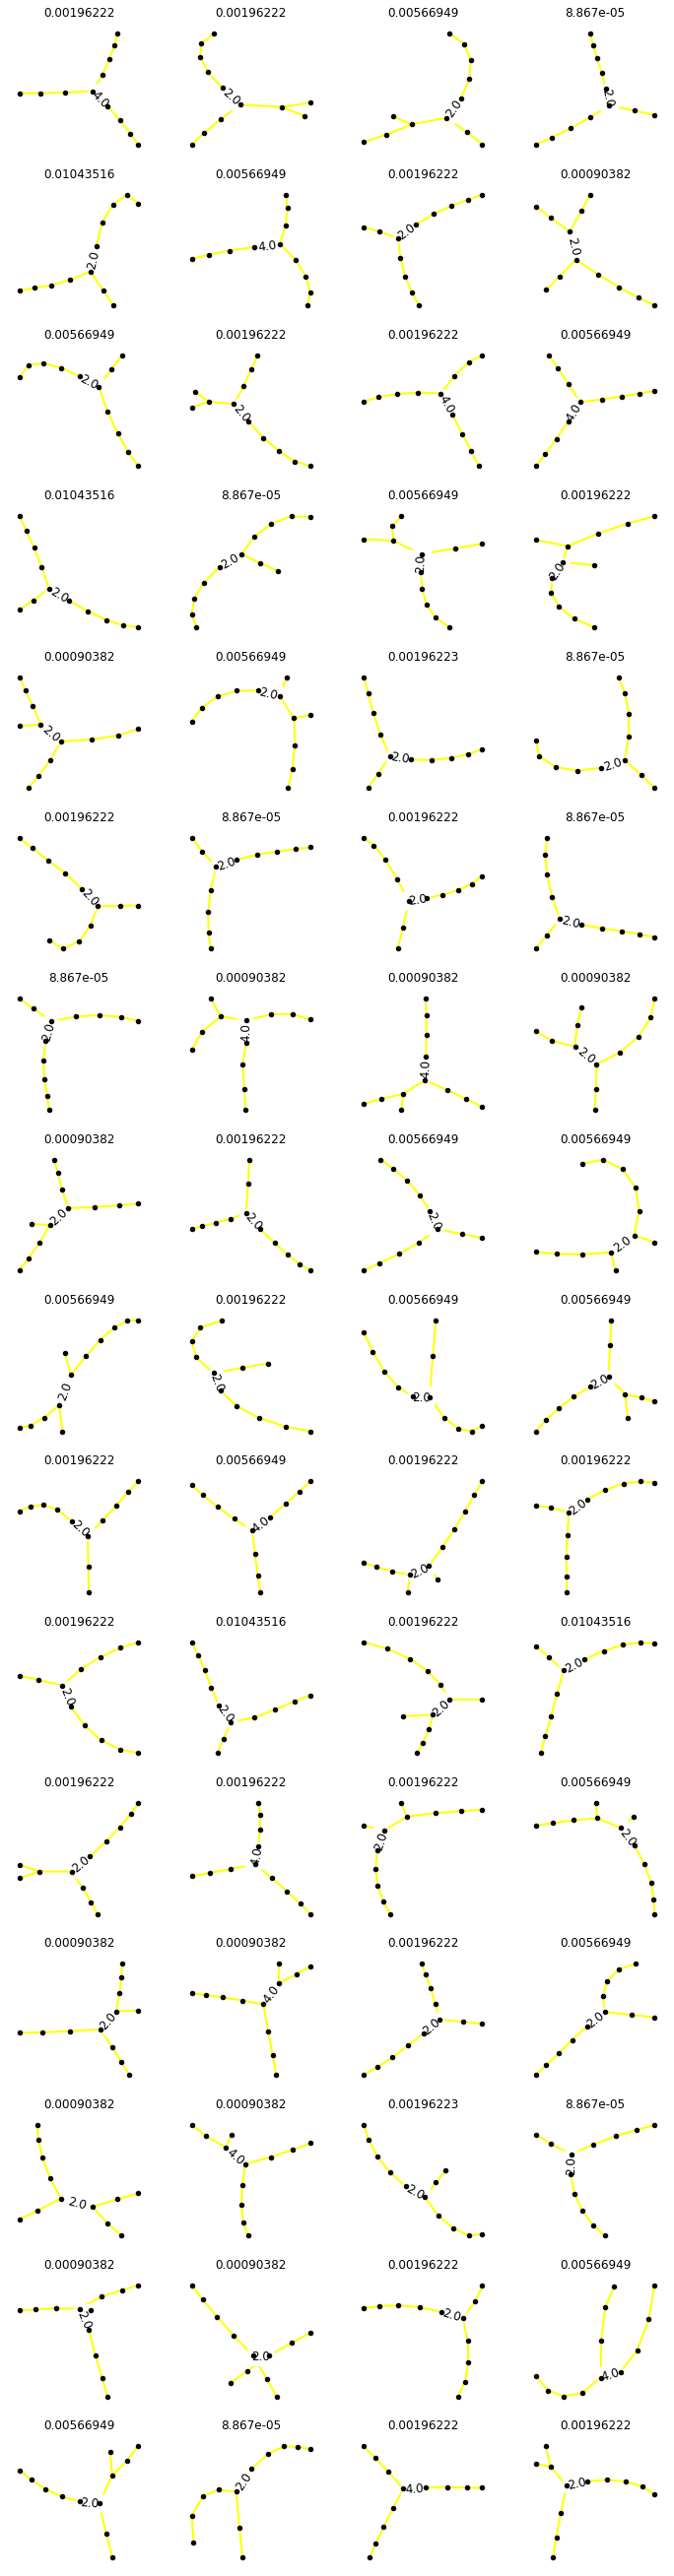

In [18]:
G = nx.Graph()
nx.add_path(G,(0,1,2,3,4,5,6,7,8,9,10,11,4))
nx.add_path(G,(2,5,10))
nx.add_path(G,(1,6,9))
nx.add_path(G,(0,7))
drawbadfair(G,1)
N = matrixtree(G)
n = len(G.nodes())
mod,rho,lamb = matrix_modulus(N,p=2, sigma=None)
print(rho)
var = (1/mod)/n - ((2*n-2)**2)/(n**2)
print('var=',round(var,5))
la = np.round(lamb/sum(lamb),8)
print('maxla=',max(la))


[0.16666667 0.16666667 0.16666667 0.16666667]
var= 0.0
number of fair trees = 4
number of unsplittable fair trees = 0
number of trees = 8
expected value of cut =  0.0


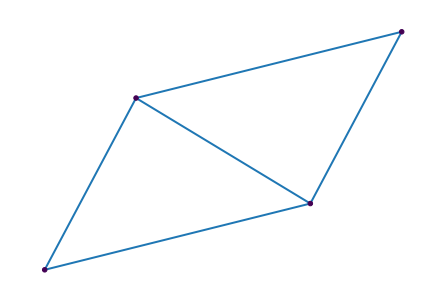

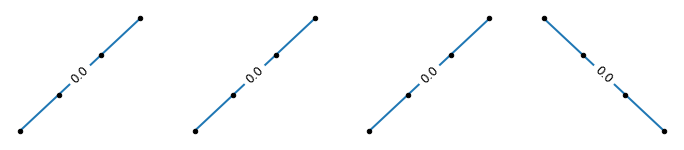

In [19]:
G = nx.Graph()
nx.add_path(G,(0,1,2,3,0))
nx.add_path(G,(1,3))
N = matrixtree(G)
n = len(G.nodes())
mod,rho,lamb = matrix_modulus(N,p=2, sigma=None)
print(rho)
var = (1/mod)/n - ((2*n-2)**2)/(n**2)
print('var=',round(var,5))
la = np.round(lamb/sum(lamb),8)
#print(la)
drawfair(G,1)

number of fair trees = 125
number of unsplittable fair trees = 5
number of trees = 125
expected value of cut =  1.0284672000000004
[0.125 0.125 0.125 0.125 0.125]
var= 0.0
[0.00284672 0.00505798 0.00505798 0.00505798 0.00505798 0.00505798
 0.00505798 0.00505798 0.01137146 0.01137146 0.01137146 0.01137146
 0.00505798 0.01137146 0.01137146 0.00505798 0.00505798 0.00505798
 0.00505798 0.01137146 0.01137146 0.01137146 0.01137146 0.01137146
 0.00505798 0.01137146 0.00505798 0.01137146 0.01137146 0.01137146
 0.01137146 0.01137146 0.01137146 0.00505798 0.00284672 0.00505798
 0.00505798 0.00505798 0.00505798 0.00505798 0.01137146 0.01137146
 0.00505798 0.00505798 0.01137146 0.00505798 0.01137146 0.01137146
 0.01137146 0.00505798 0.00505798 0.00505798 0.00505798 0.01137146
 0.00505798 0.01137146 0.01137146 0.01137146 0.00505798 0.01137146
 0.01137146 0.01137146 0.00505798 0.01137146 0.01137146 0.01137146
 0.01137146 0.01137146 0.00505798 0.00505798 0.00505798 0.01137146
 0.00505798 0.01137146 0

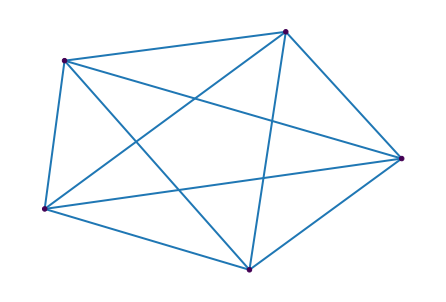

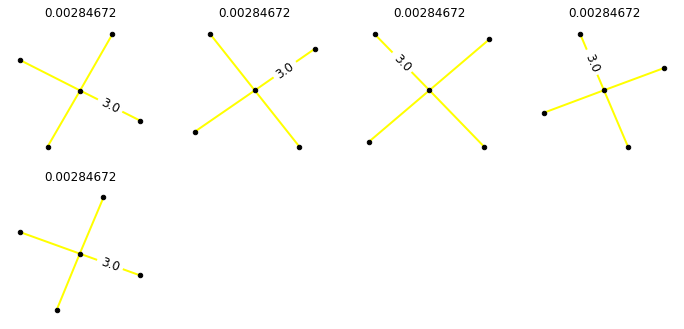

In [20]:
G = nx. complete_graph(5)
drawbadfair(G,1)
N = matrixtree(G)
mod,rho,lamb = matrix_modulus(N,p=2, sigma=None)
la = np.round(lamb/sum(lamb),8)
n = len(G.nodes())
print(rho)
var = (1/mod)/n - ((2*n-2)**2)/(n**2)
print('var=',round(var,5))
print(la)